In [78]:
# !pip install scikit-image

In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage as ski
import os
from pathlib import  Path
import PIL
import numpy as np

(4032, 3024)


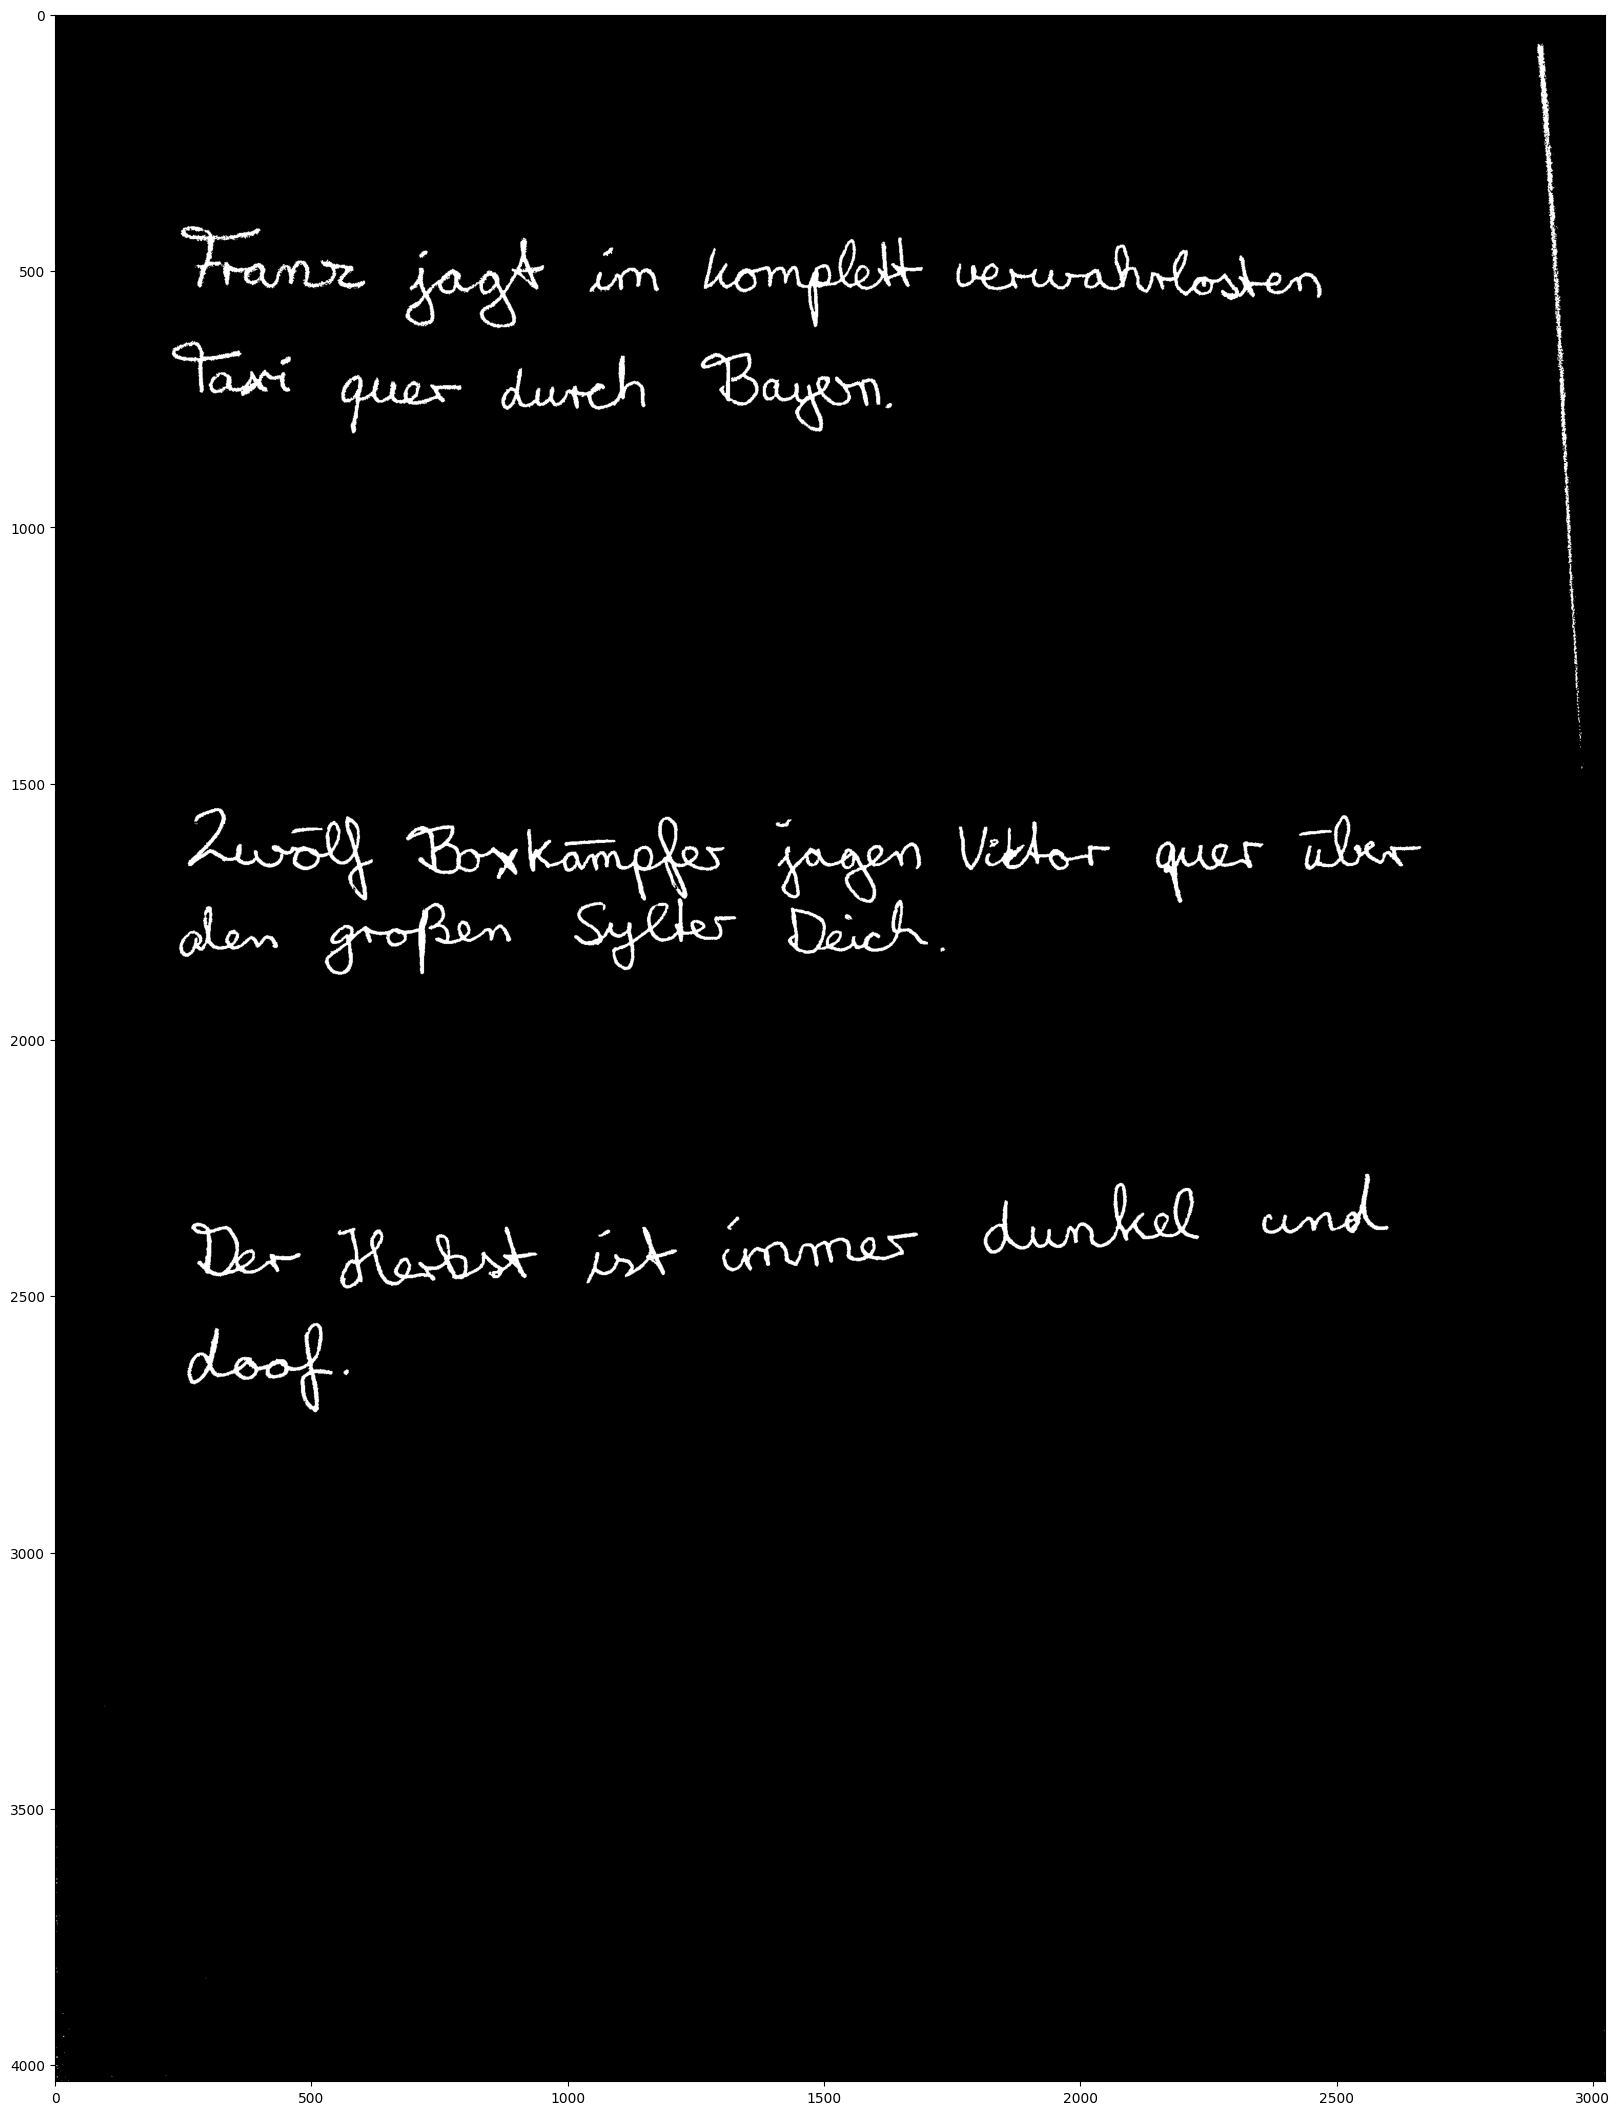

In [80]:
#img_path = Path('/home/jv/Bilder/010.jpeg')
img_path = Path('/home/jv/Bilder/014.jpeg')
#img = ski.io.imread(img_path, plugin='pil')
#img = PIL.Image.open(img_path)

from cv2 import imread
img = imread(f"{img_path}")[:,:,::-1]
orig_img = img.copy()

plt.set_cmap('gray')

# transform to gray
img = ski.color.rgb2gray(img)
print(img.shape)

# threshhold
thresh_sauvola = ski.filters.threshold_sauvola(img, window_size=101)


# plt.rcParams["figure.figsize"] = (20,30)
# fig, axs = plt.subplots(1,2)
# plt.axis('off')
# axs[0].imshow(img <= thresh_sauvola)

img = img <= thresh_sauvola
plt.imshow(img)

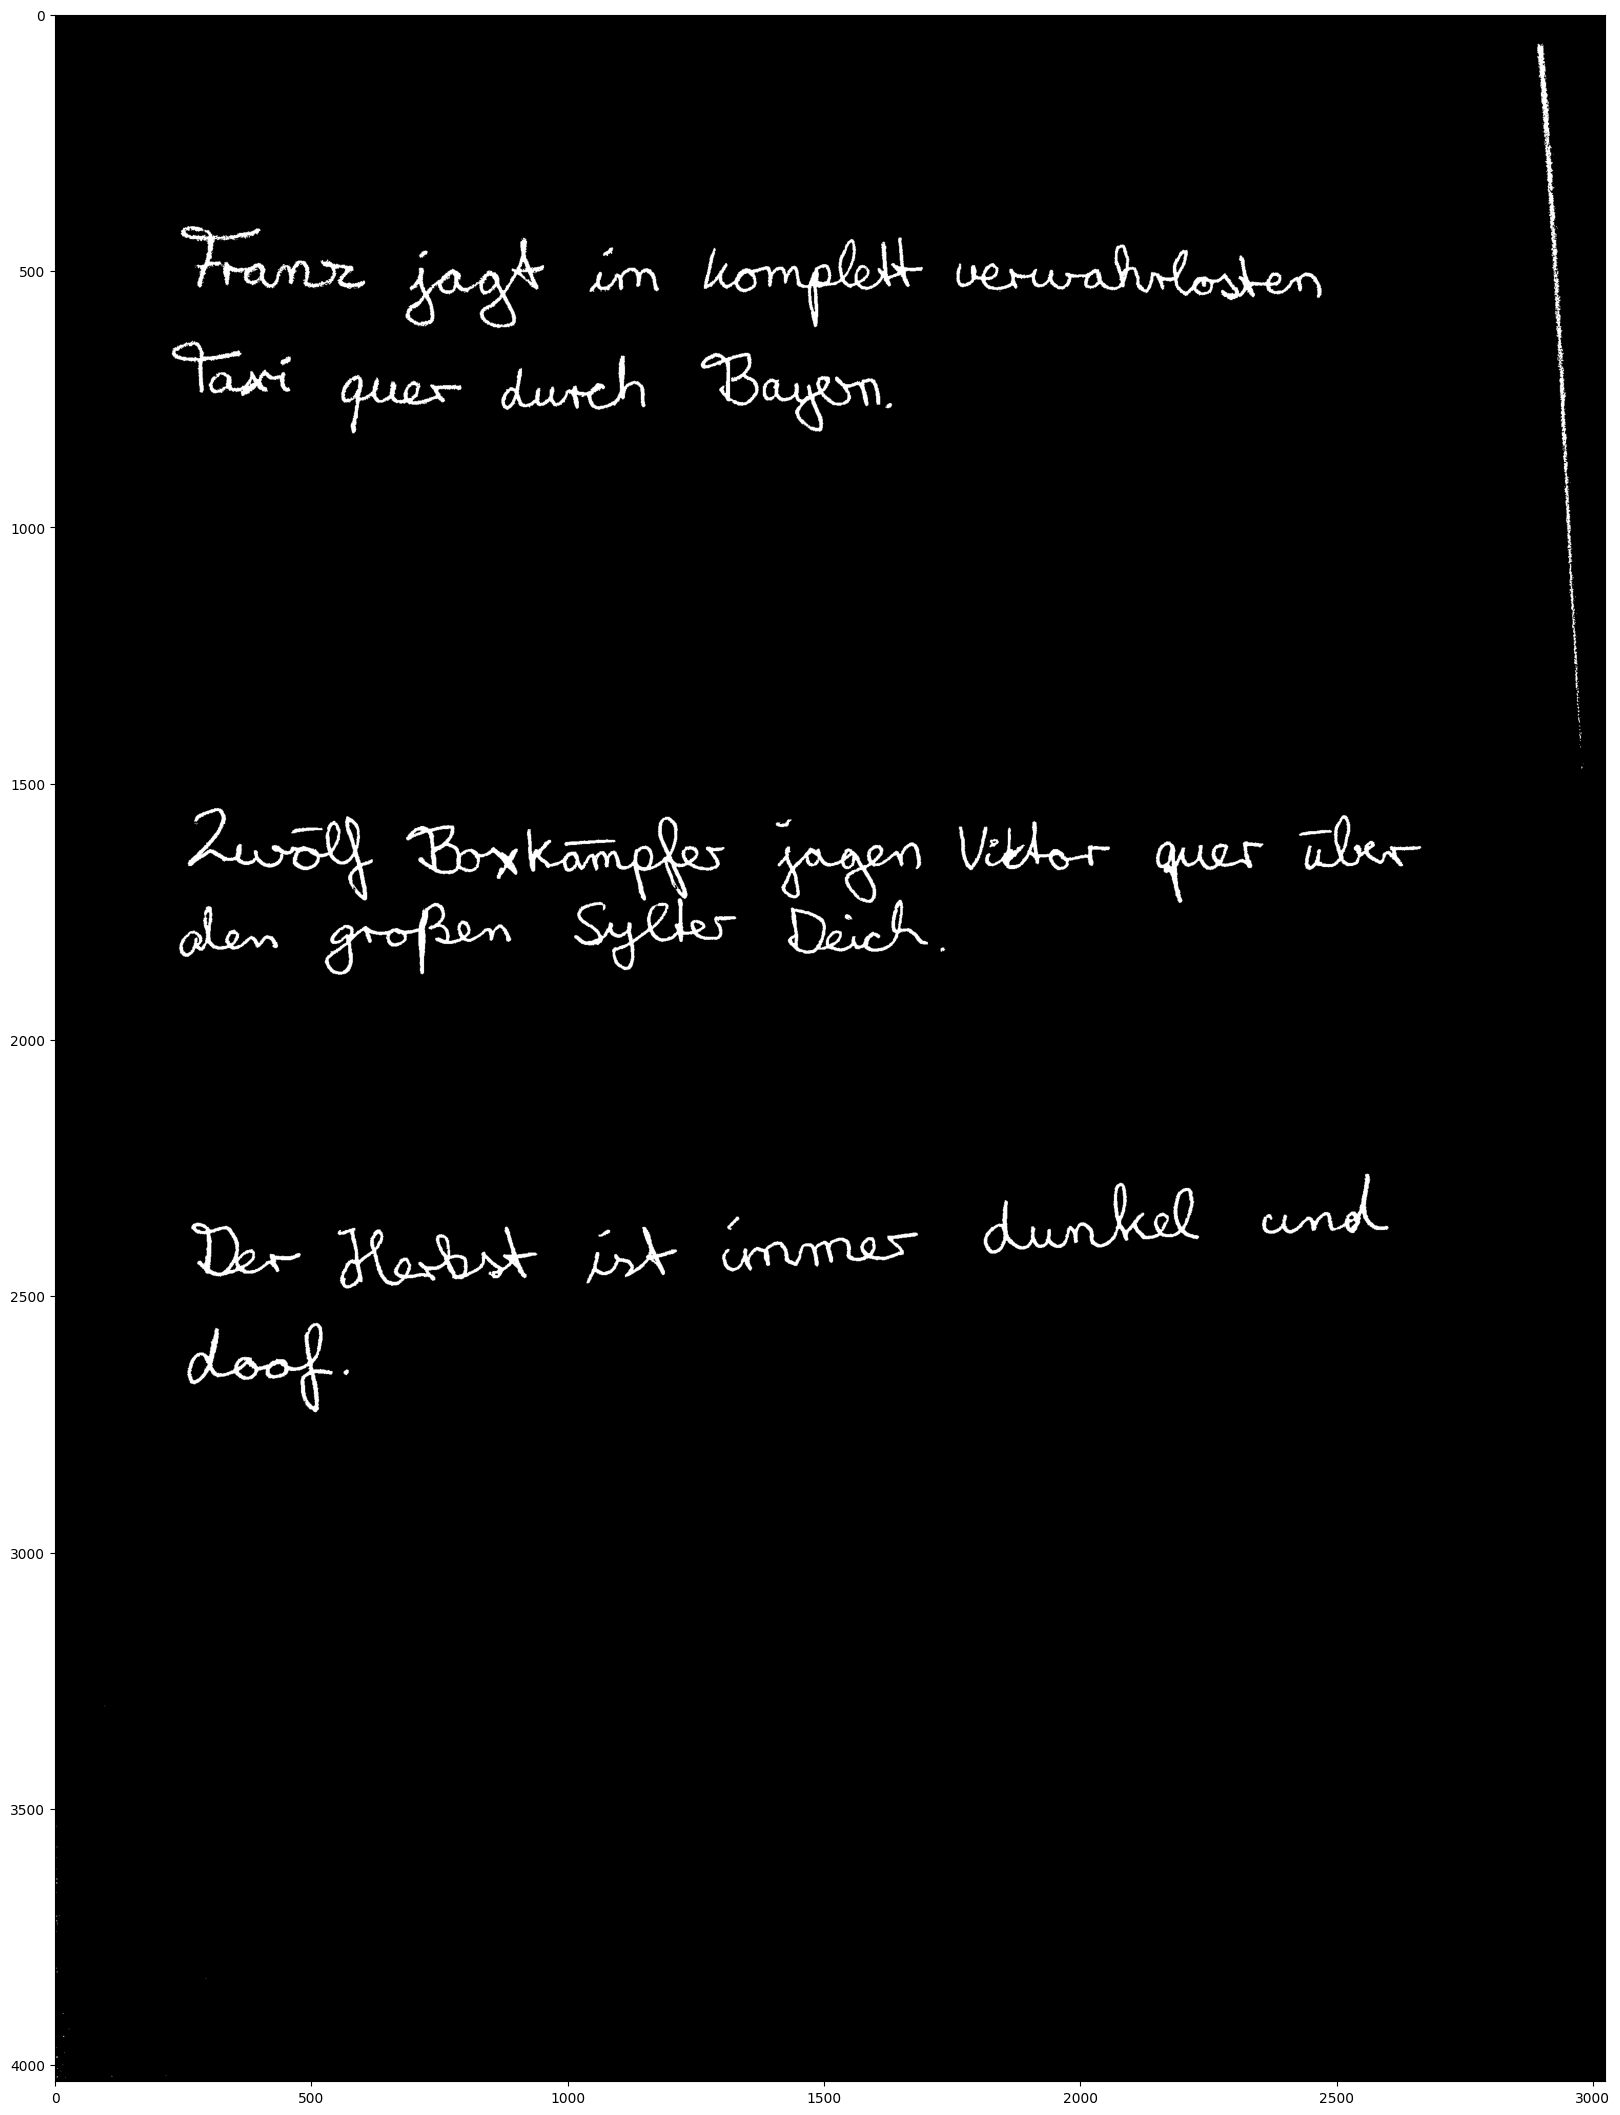

In [81]:
img = ski.segmentation.clear_border(img)
plt.imshow(img)

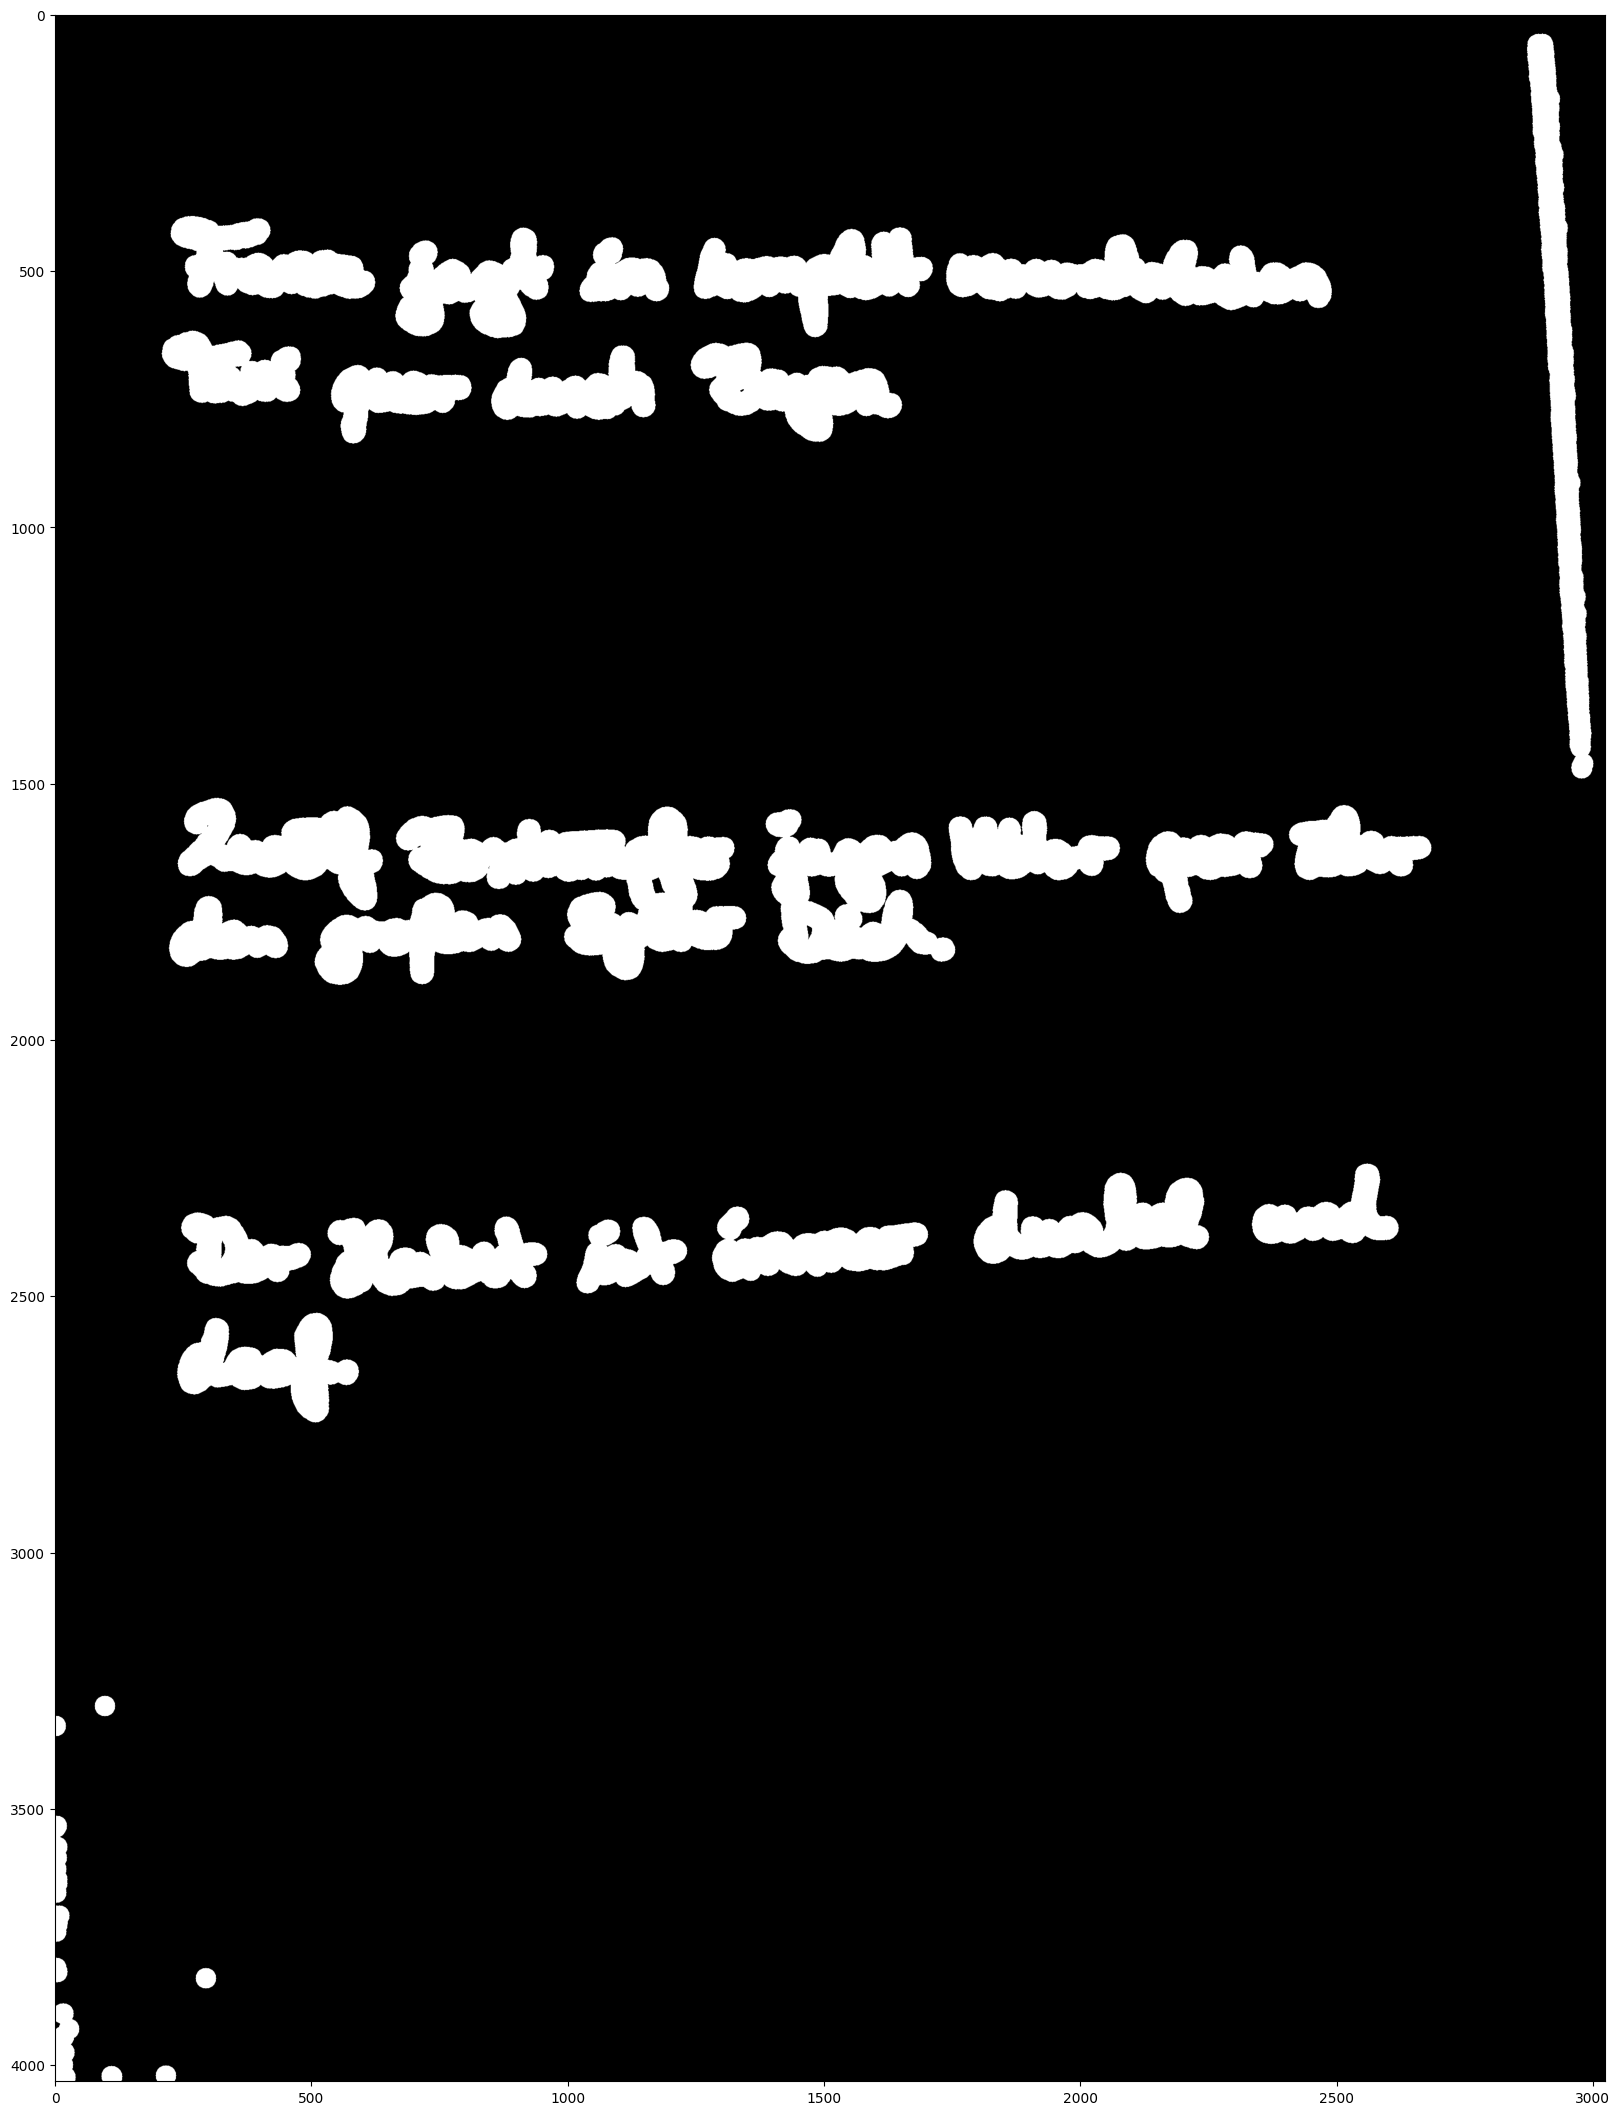

In [82]:
img = ski.morphology.isotropic_dilation(img, radius=20) #, footprint=ski.morphology.rectangle(2,300, decomposition='sequence')))
plt.imshow(img)

In [272]:
def draw_box(axis, box, **kwargs):
    y_min, x_min, y_max, x_max = box
    axis.add_patch(mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max-y_min, **kwargs))


def draw_boxes(axis, boxes, **kwargs):
    for box in boxes:
        draw_box(axis, box, **kwargs)


def overlap(box1, box2) -> bool:
    """Check if BOX1 and BOX2 overlap.
    Boxes are scikit image regions (ytop,xtop,ybot,ybot)."""
    
    y1_min, x1_min, y1_max, x1_max = box1
    y2_min, x2_min, y2_max, x2_max = box2

    # No overlap if area == 0
    if y1_min == y1_max or x1_min == x1_max or y2_min == y2_max or x2_min == x2_max:
        return False
    
    # No overlap if one rectangle is on left side of the other
    if x1_min > x2_max or x2_min > x1_max:
        return False
    
    # No overlap if one rectangle is above another:
    if y1_min > y2_max or y2_min > y1_max:
        return False
    
    return True


def pad_box(box, x_dist, y_dist, img):
    """Return a box padded by x_dist and y_dist, respeting IMGs dimensions."""
    y_min, x_min, y_max, x_max = box

    w, h = img.shape 

    print(f"Padding box {box}")

    return (max(y_min - y_dist, 0), max(x_min - x_dist, 0),
            min(y_max + y_dist, h), min(x_max + x_dist, w))


def touching_boxes(box, candidates, x_dist, y_dist, img):
    padded_box = pad_box(box, x_dist, y_dist, img)
    return [ cand for cand in candidates if overlap(padded_box, cand) ]


def greedy_collect(seed : tuple, candidates : list, x_dist, y_dist, img) -> list:
    if not seed:
        return []
    if not candidates:
        return [ seed ]
    res = [ seed ]
    new_seeds = touching_boxes(seed, candidates, x_dist, y_dist, img)
    for new_seed in new_seeds:
        res += greedy_collect(new_seed, list(set(candidates) - set(res)), x_dist, y_dist, img)
    
    return list(set(res))


def bounding_box(boxes:list ) -> tuple:
    y_min = min([b[0] for b in boxes])
    x_min = min([b[1] for b in boxes])
    y_max = max([b[2] for b in boxes])
    x_max = max([b[3] for b in boxes])
    return (y_min, x_min, y_max, x_max)


# delete tnis
def check_box(box, candidates, x_dist, y_dist, img, axis):
    padded_box = pad_box(box, x_dist, y_dist, img)
    draw_box(axis, box, color='yellow') 
    draw_box(axis, padded_box, fill=False, edgecolor='blue')
    for cand in candidates:
        if overlap(padded_box, cand):
            color='orange'
        else:
            color='gray'
        draw_box(axis, cand, color=color)


(4032, 3024)
Padding box (394, 225, 556, 625)
Padding box (394, 225, 556, 625)
Padding box (684, 538, 838, 813)
Padding box (684, 538, 838, 813)
Padding box (416, 664, 633, 974)
Padding box (435, 1023, 562, 1199)
Padding box (435, 1023, 562, 1199)
Padding box (641, 1240, 835, 1653)
Padding box (641, 1240, 835, 1653)
Padding box (429, 1738, 578, 2491)
Padding box (429, 1738, 578, 2491)
Padding box (416, 1246, 631, 1713)
Padding box (646, 851, 792, 1172)
Padding box (646, 851, 792, 1172)
Padding box (416, 1246, 631, 1713)
Padding box (416, 1246, 631, 1713)
Padding box (646, 851, 792, 1172)
Padding box (416, 1246, 631, 1713)
Padding box (429, 1738, 578, 2491)
Padding box (646, 851, 792, 1172)
Padding box (416, 1246, 631, 1713)
Padding box (646, 851, 792, 1172)
Padding box (416, 1246, 631, 1713)
Padding box (641, 1240, 835, 1653)
Padding box (646, 851, 792, 1172)
Padding box (416, 1246, 631, 1713)
Padding box (416, 664, 633, 974)
Padding box (646, 851, 792, 1172)
Padding box (646, 851, 792

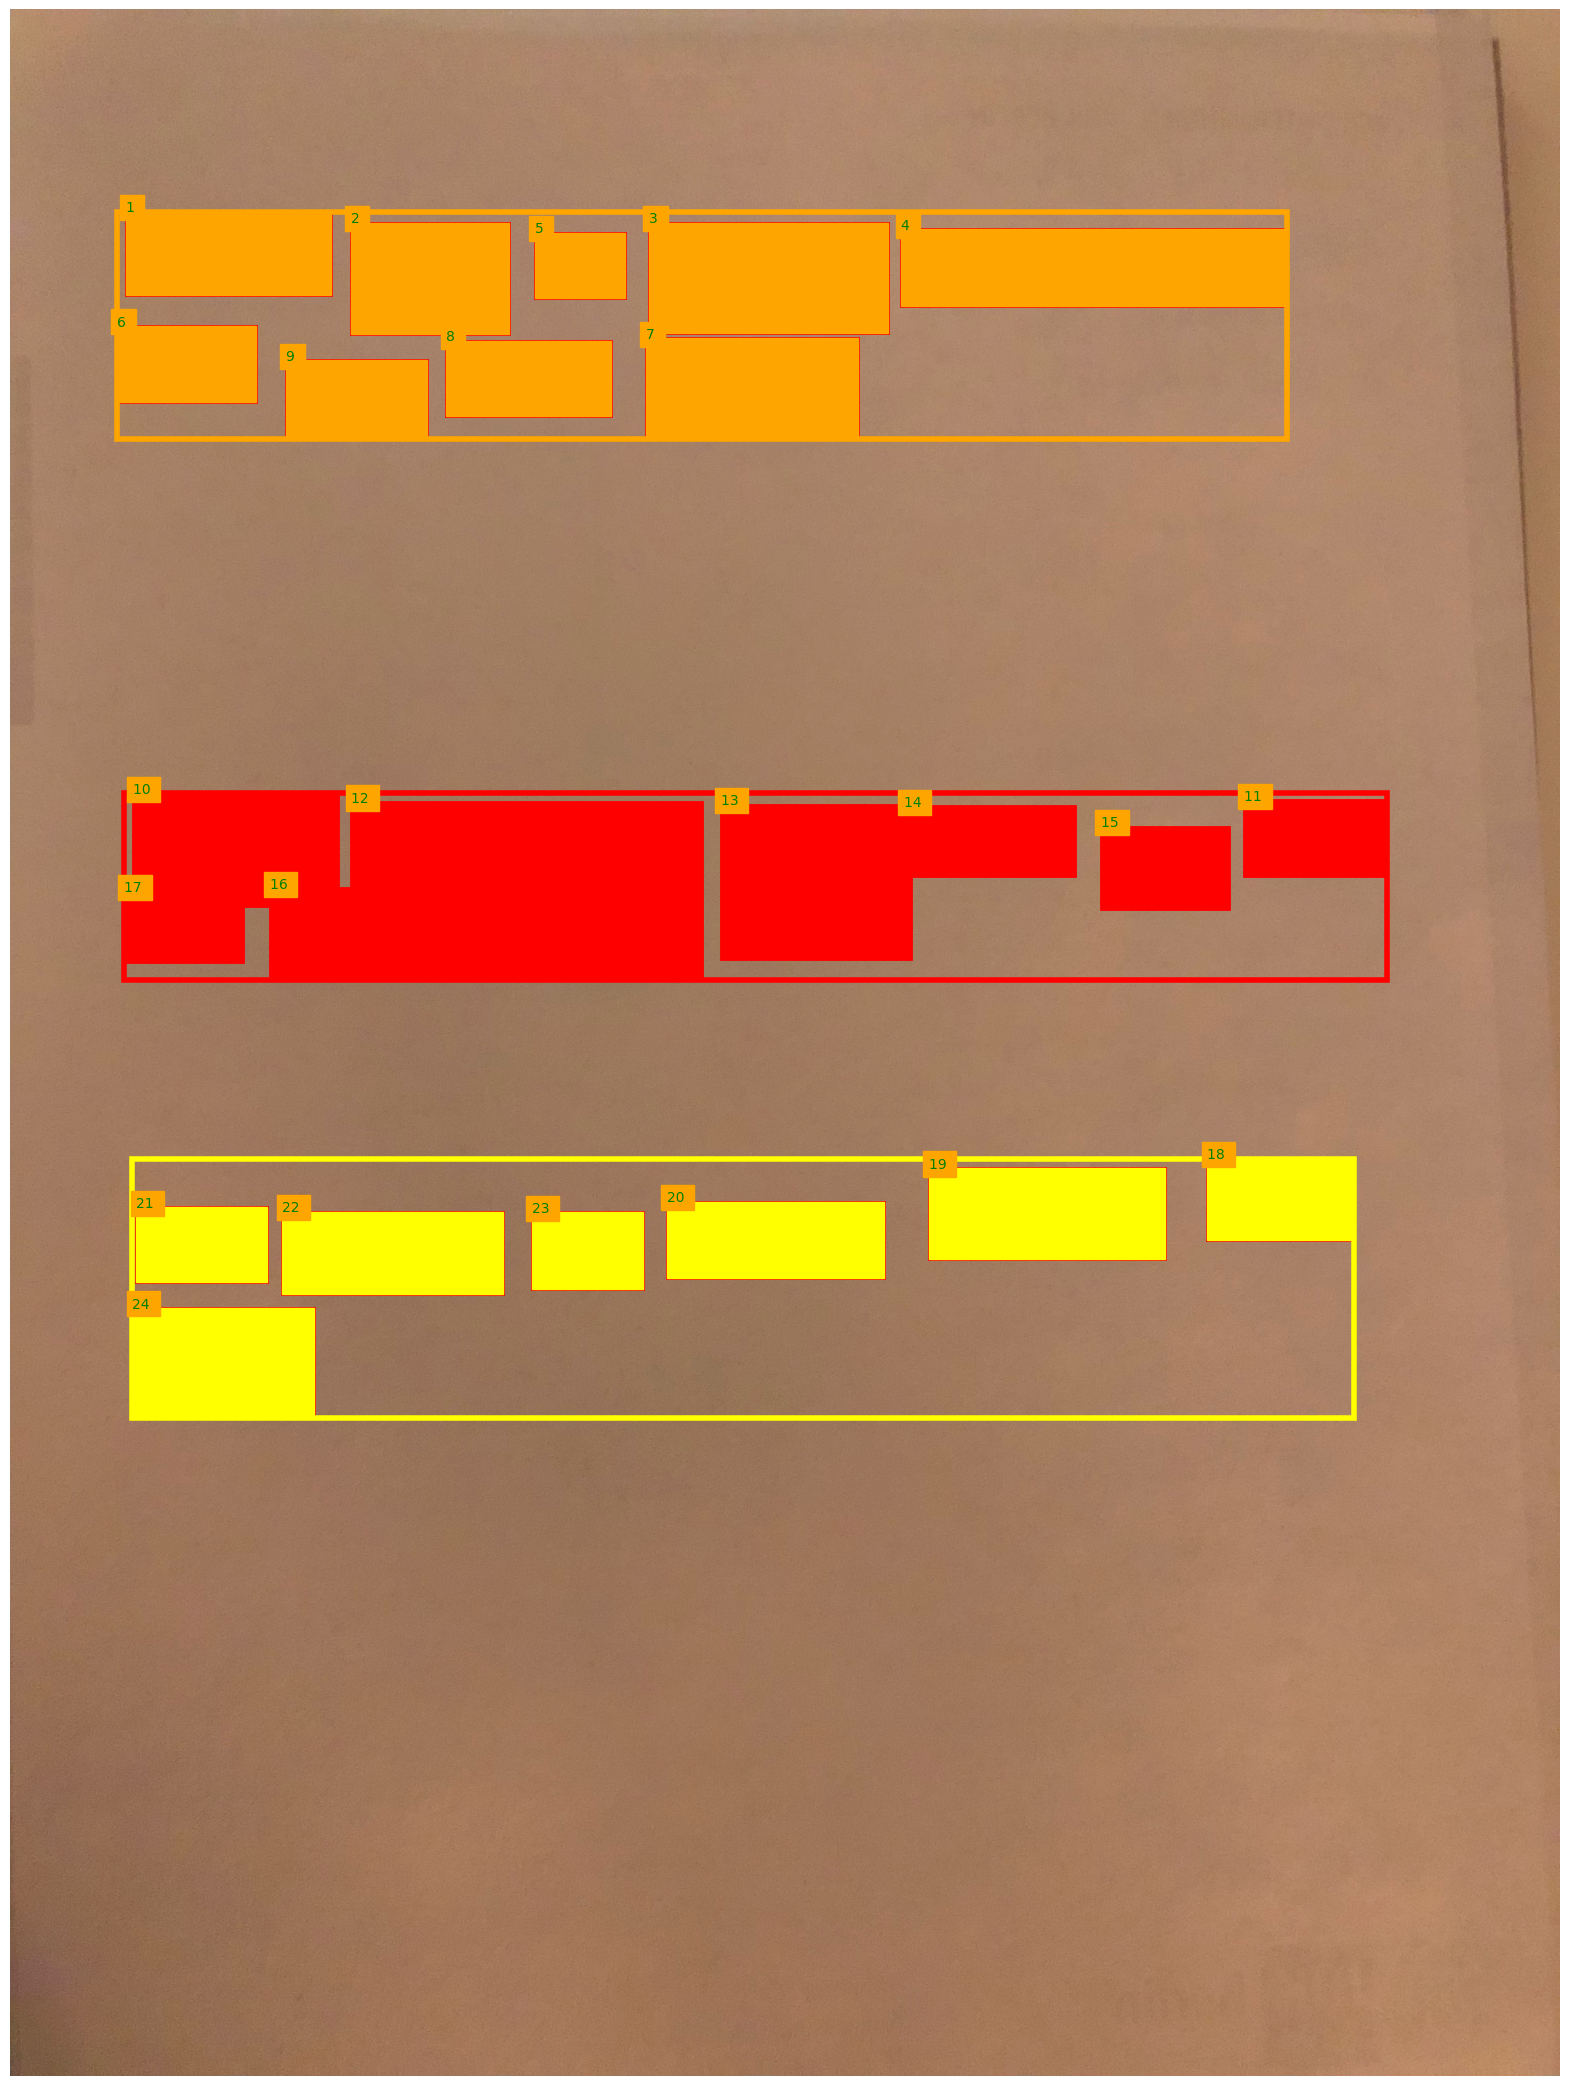

In [282]:
import matplotlib.patches as mpatches
import math

# label
label_img = ski.measure.label(img, connectivity=img.ndim)
props = ski.measure.regionprops(label_img)

images = []
boxes = []
x_dim, y_dim = img.shape
print(img.shape)

fig, ax = plt.subplots()
ax.imshow(orig_img)
for i, region in enumerate(props):
    # take regions with large enough areas
    #print(region.area, region.extent)
    y_min, x_min, y_max, x_max = region.bbox # y,x (!)
    height = y_max - y_min
    width = x_max - x_min
    one_third_x = width > (x_dim / 3)
    one_third_y = height > (y_dim / 3) 
    if round(region.extent,2) < 0.75 and not one_third_x and not one_third_y:
        images += [ orig_img[y_min:y_max, x_min:x_max] ]
        boxes  += [ region.bbox ] 
        text = f"{i} "
        plt.text(x_min, y_min, text, color='green', backgroundcolor='orange') #, va='center', ha='center'))
        rect = mpatches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

# max_dist = (150, 150)
# print (max_dist)
# check_box(boxes[0], boxes[1:], max_dist[0], max_dist[1], img, ax)

joined_boxes = []
color_index = 0
colors=['grey', 'orange', 'red', 'yellow', 'green']
while boxes: 
    group = greedy_collect(boxes[0], boxes, 150, 150, img)
    joined_boxes += [ group ]
    color_index += 1
    draw_boxes(ax, group, color=colors[color_index])
    boxes = list(set(boxes) - set(group))

color_index = 0
for group in joined_boxes:
    print("Group:", group)
    color_index += 1
    draw_box(ax, bounding_box(group), fill=False, linewidth=4, edgecolor=colors[color_index])

ax.set_axis_off()
plt.savefig("test.png", pad_inches=0, bbox_inches='tight')
plt.show()
plt.close(fig)

 


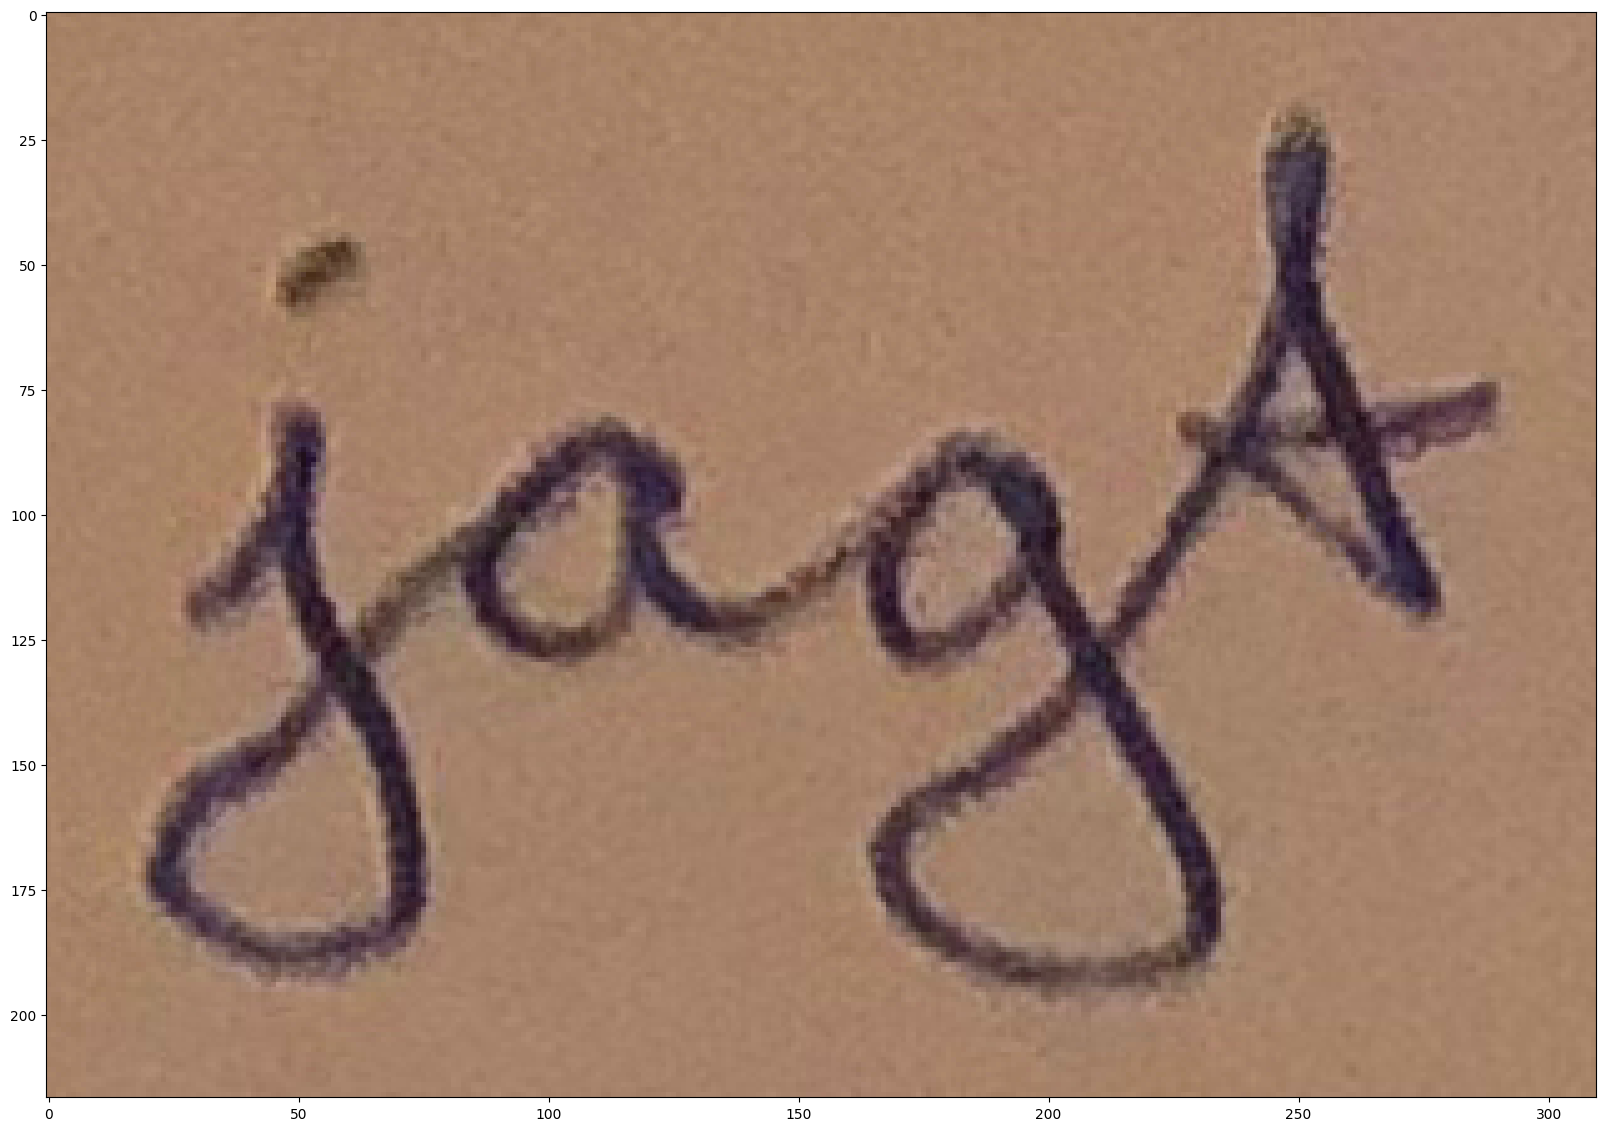

In [149]:
plt.imshow(images[2])

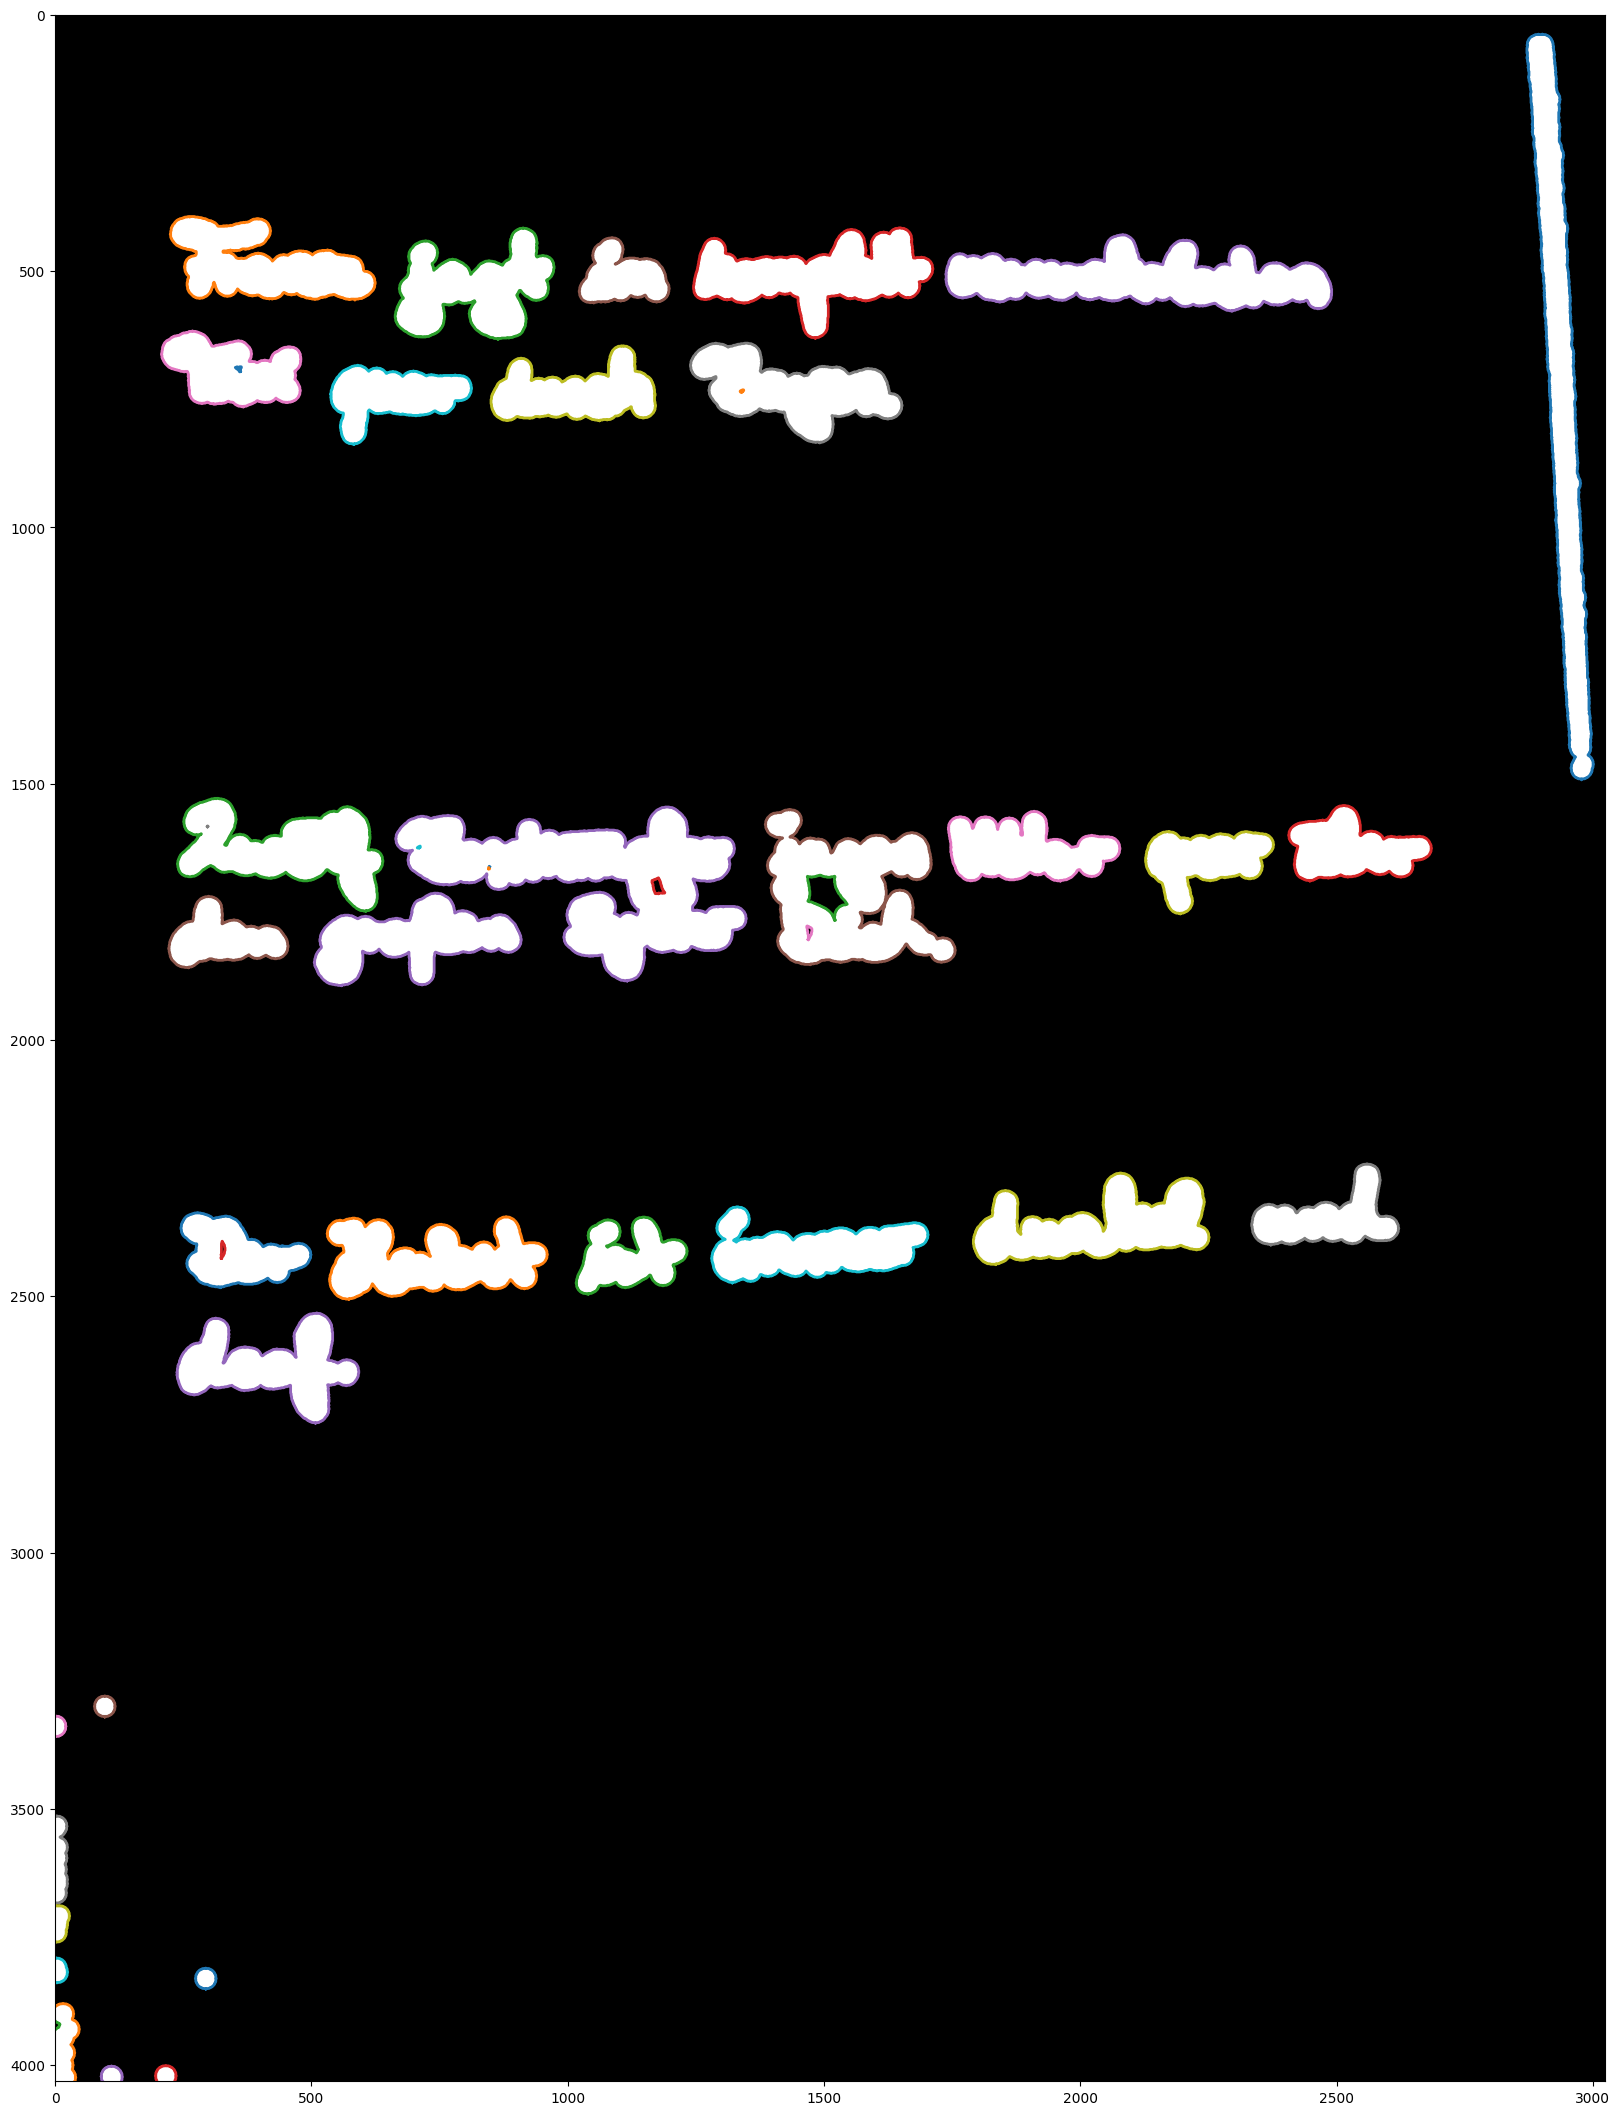

In [83]:
# find countours
contours = ski.measure.find_contours(img)
fig, ax = plt.subplots()
ax.imshow(img)
for contour in contours:
    ax.plot(contour[:,1], contour[:,0], linewidth=2)
plt.show()

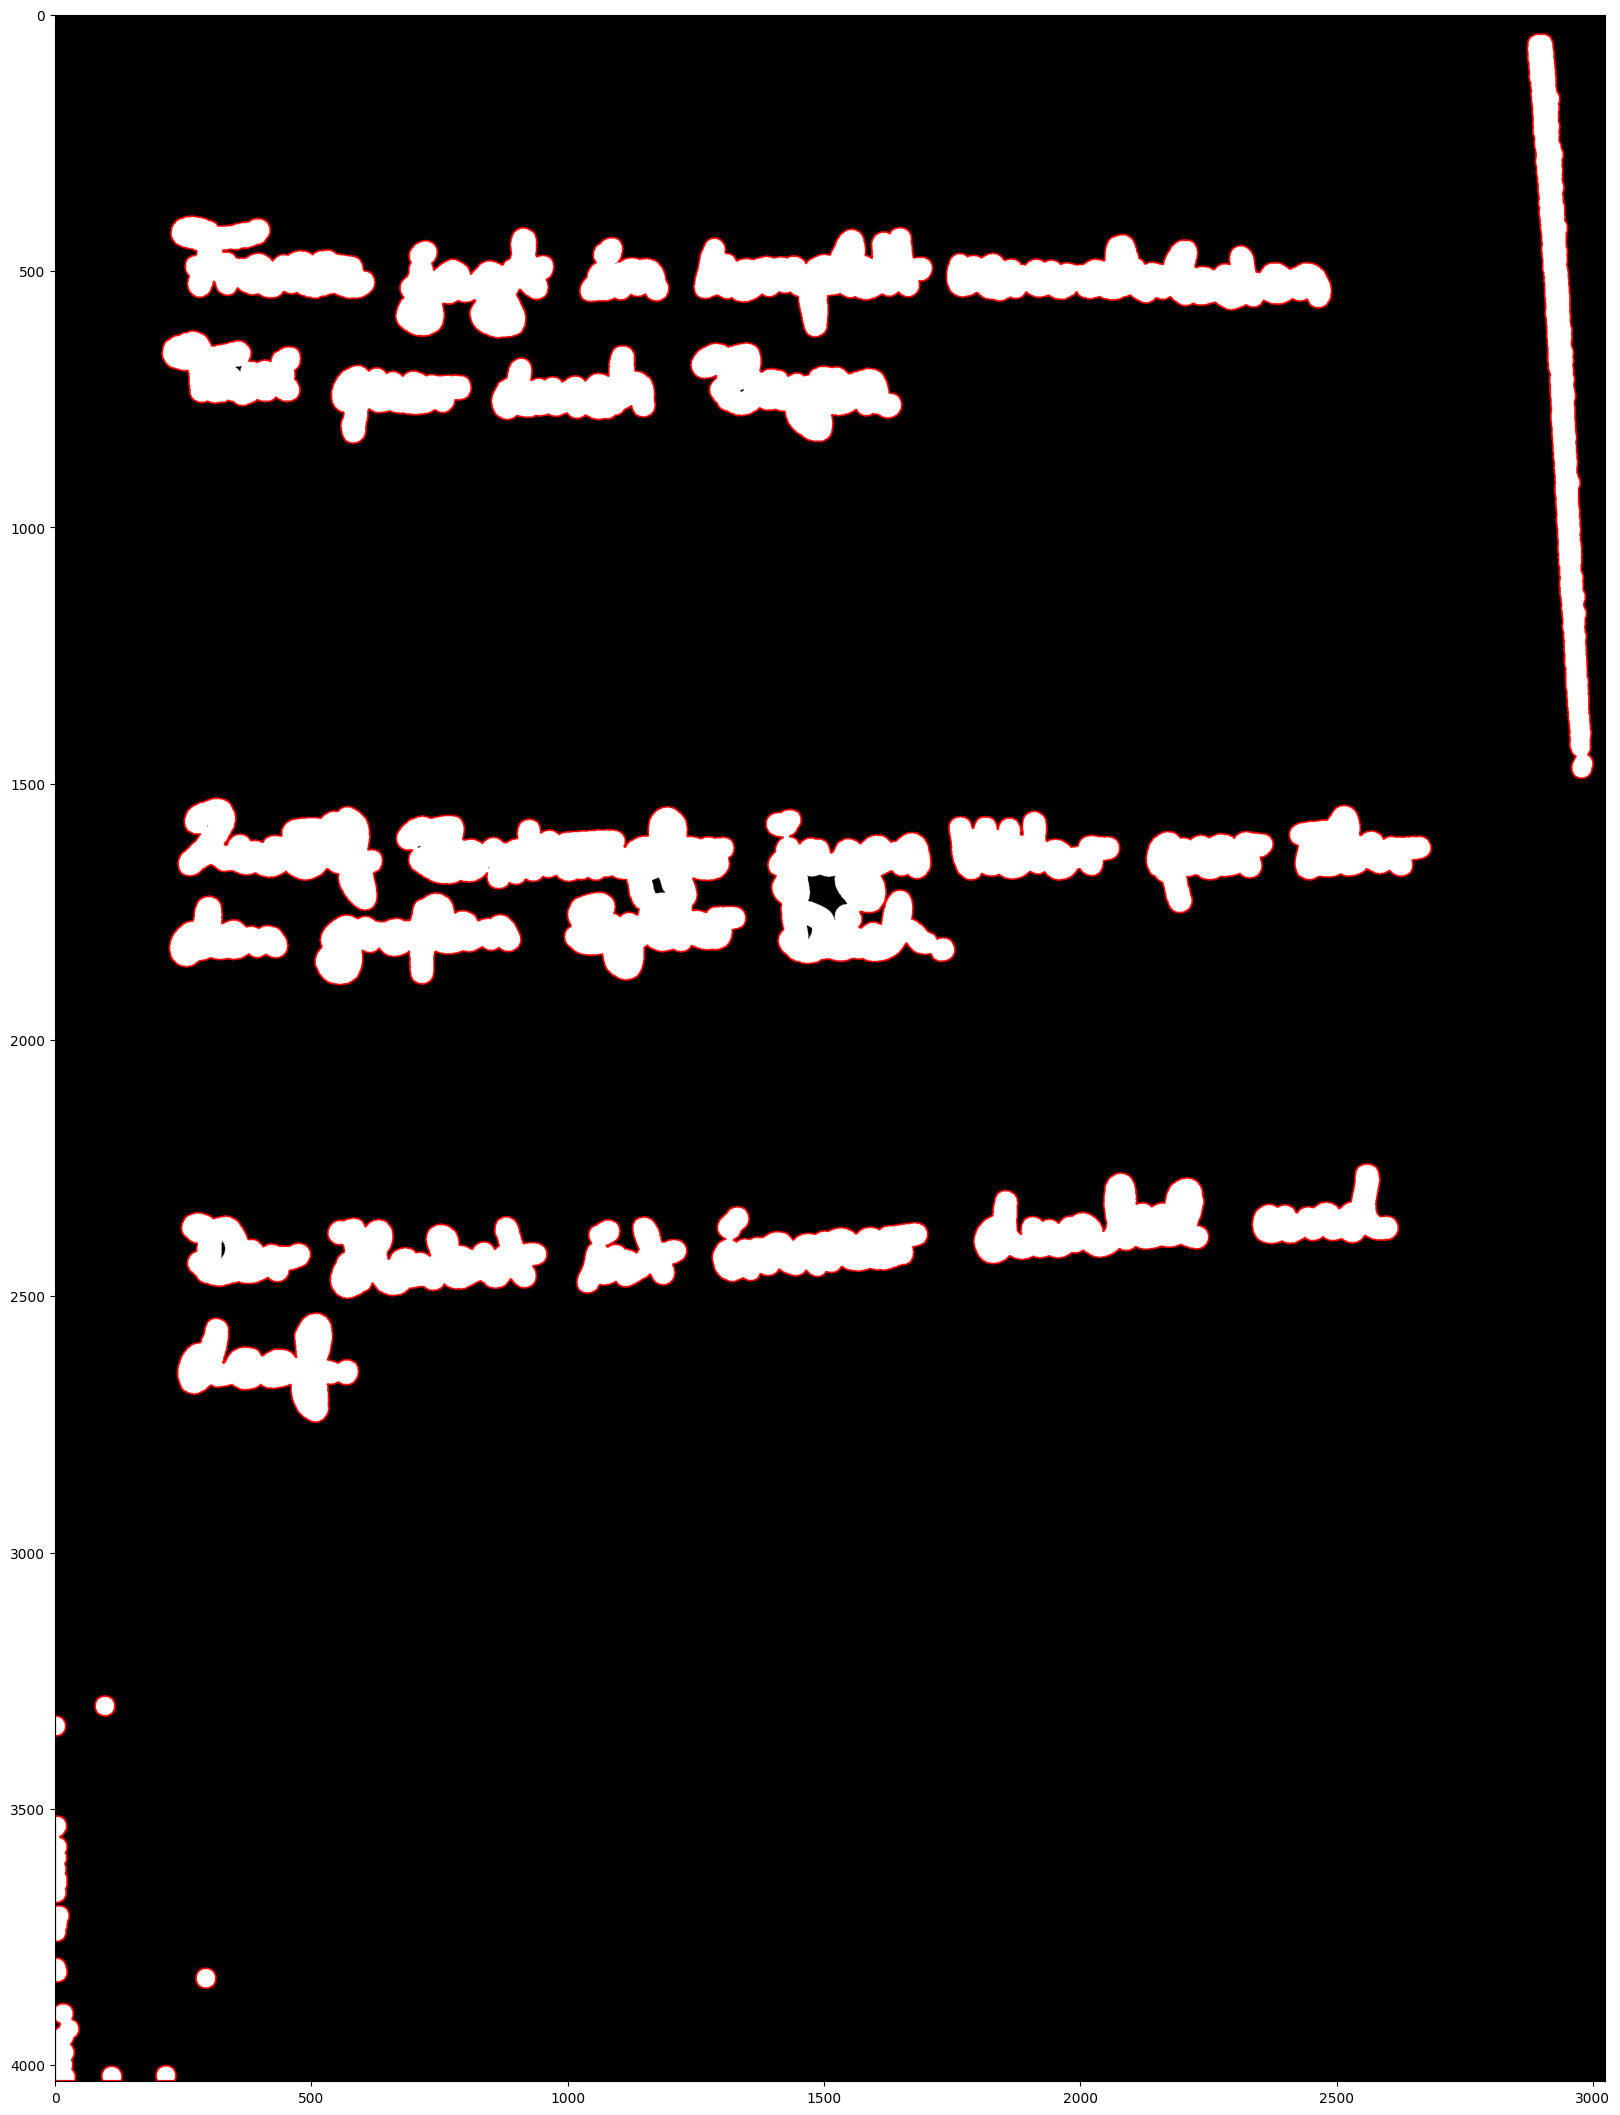

In [111]:
import cv2

cntrs, hierachy = cv2.findContours(ski.util.img_as_ubyte(img), 
                                   cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

             
cv2img = ski.util.img_as_ubyte(img) # cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2img = cv2.cvtColor(cv2img, cv2.COLOR_BGR2RGB)
cv2img = cv2.drawContours(cv2img, cntrs, -1, color=(255,0,0),
                                    thickness=2)
fig, ax = plt.subplots()
plt.imshow(ski.util.img_as_float(cv2img))

#plt.show(ski.util.img_as_float(cv2img, True))


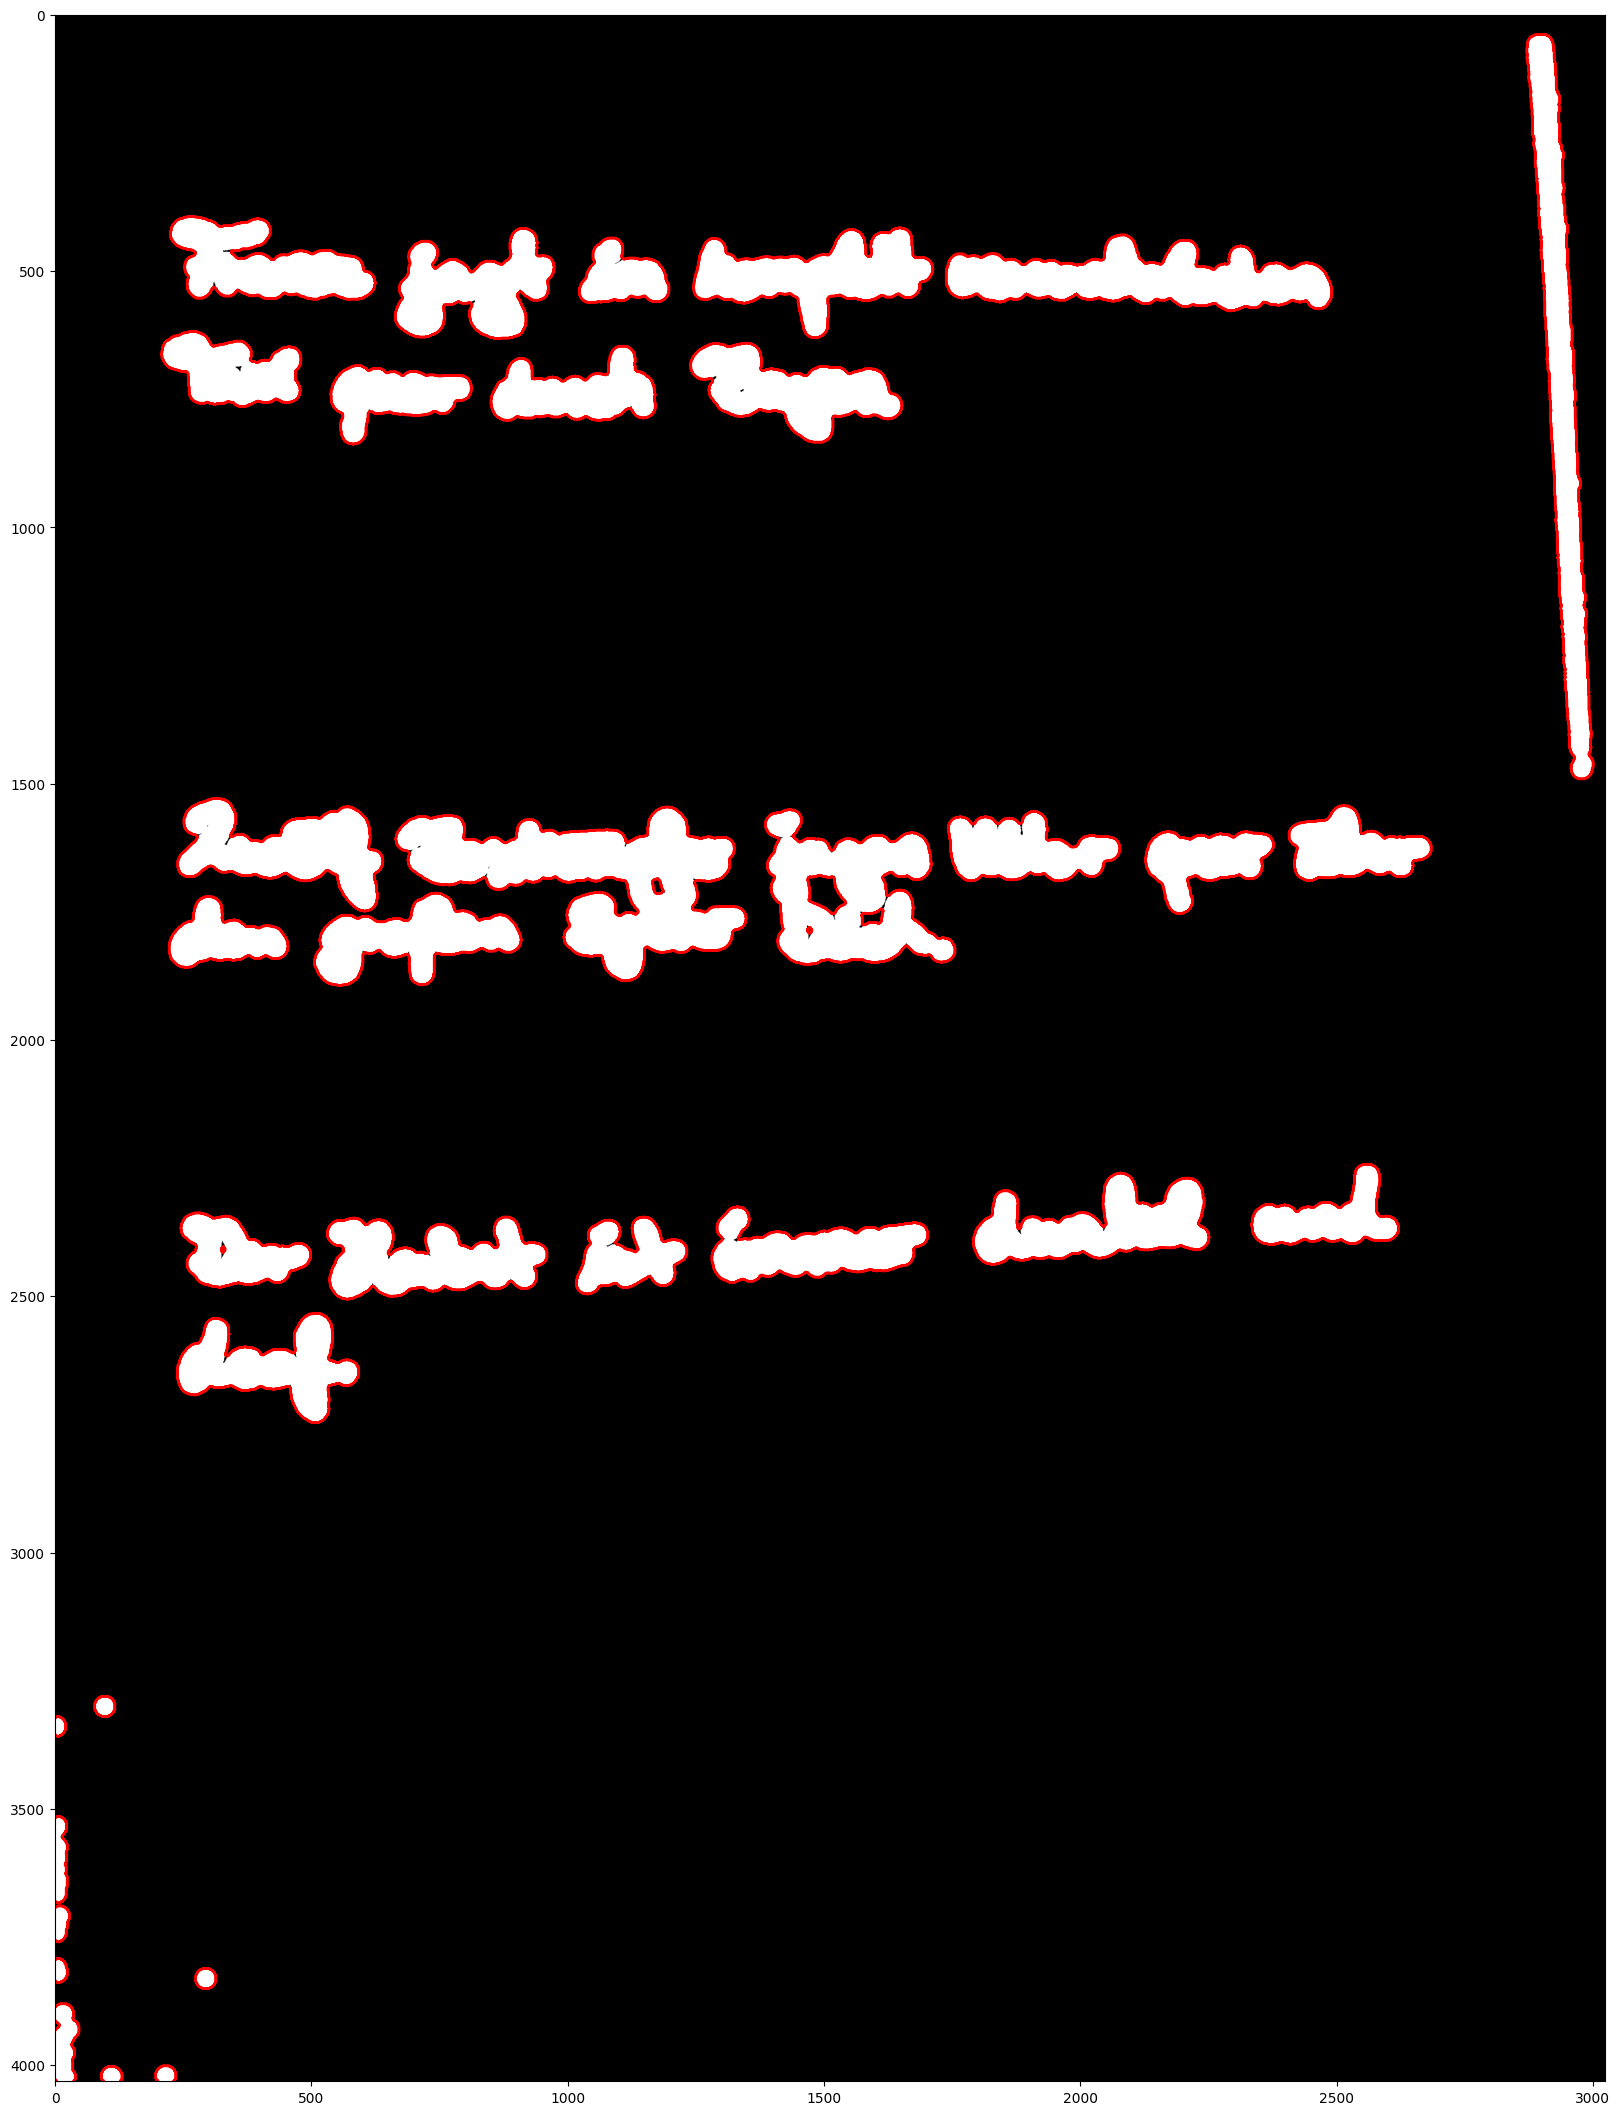

In [76]:
ls = ski.segmentation.morphological_chan_vese(img, 
                                              num_iter=15, 
                                              init_level_set=ski.segmentation.checkerboard_level_set(img.shape,3),
                                              smoothing=3)

plt.contour(ls, colors='r')
plt.imshow(img)